In [3]:
import numpy as np
import matplotlib.pyplot as plt
import segyio

The data set we'll use in this example is the Kerry 3d in the Taranaki Basin offshore New Zealand. This data set has plenty of fault structures, and the volume is only 1.0 GB in size so isn't too unwieldy.

For more about the dataset: https://dataunderground.org/dataset/kerry

This assumes that you have already downloaded the data set and placed it inside a relative folder called `data`. If you don't have that configuration, go ahead and do that now.

In [4]:
fname = 'data/Kerry3D.segy'

In [6]:
with segyio.open(fname, strict=False) as s:
    data = np.stack(t.astype(np.float) for t in s.trace)

/Users/Evan/miniconda3/envs/geocomp/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


Unfortunately, the inline and xline coordinates are in the non-standard location in this file so we aren't able to use `segyio.cube()` to construct a 3d NumPy array. Instead, we can inspect the textual header, and luckily we can work out how to reshape the data based on the inline and cross line ranges stated on lines `C09` and `C10` below.

With a bit more work we can also read the file header and the trace headers.

In [7]:
def chunks(s, n):
    """Produce `n`-character chunks from string `s`."""
    for start in range(0, len(s), n):
        yield s[start:start + n]

with segyio.open(fname, strict=False) as s:
    
    # Read the data.
    data = np.stack(t.astype(np.float) for t in s.trace)
    
    # Get the (x, y) locations.
    x = [t[segyio.TraceField.GroupX] for t in s.header]
    y = [t[segyio.TraceField.GroupY] for t in s.header]
    
    # Get the trace numbers.
    cdp = np.array([t[segyio.TraceField.CDP] for t in s.header])

    # Get the first textual header.
    header = s.text[0].decode('ascii')
    formatted = '\n'.join(chunk for chunk in chunks(header, 80))

    # Get data from the binary header.
    # Get the sample interval in ms (convert from microsec).
    sample_interval = s.bin[segyio.BinField.Interval] / 1000

print(formatted)

/Users/Evan/miniconda3/envs/geocomp/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if __name__ == '__main__':


C01 AREA        : OFFSHORE TARANAKI - OFFSHORE TARANAKI SEISMIC DATABASE        
C02 DESCRIPTION : KERRY3D SEISMIC COVERAGE - PHASE MATCHED IN GEOFRAME          
C03 =========================================================================== 
C04 DATE     :1996       CLASS      :RAW MIGRATION /+90 DEGREE PHASE SHIFT      
C05 OPERATOR :WMC        PROCESSING :DIGICON SINGAPORE                          
C06 =========================================================================== 
C07 THE 3D DATA HAS BEEN DATUM AND PHASE SHIFTED. DATA HAS BEEN MERGED WITH     
C08 CHECKED NAV AND EXPORTED FROM GEOFRAME 4.2 IN STANDARD SEGY.                
C09 INLINES/SP RANGE :510-796 CDP INC       :1        SAMPLE INTERVAL :4000     
C10 XLINES/CDP RANGE :58-792  SAMPLES/TRACE :1251     FINAL TIME :5000          
C11 LINE INC      :1  TRACES/LINE   :VARIABLE IL/XL X/EAST Y/NORTH              
C12 =========================================================================== 
C13 THIS DATASET WAS PREPARE

In [16]:
print(f'There are {cdp.shape[0]} traces in this 3D volume')

There are 210945 traces in this 3D volume


We can figure out the number of inlines and crosslines from this part of the nicely informative text header. Not all text headers are helpful like this!

```C09 INLINES/SP RANGE :510-796 CDP INC       :1        SAMPLE INTERVAL :4000     
C10 XLINES/CDP RANGE :58-792  SAMPLES/TRACE :1251     FINAL TIME :5000     ```

In [20]:
inline_range = abs(510-796) + 1
inline_range

287

In [21]:
xl_range = abs(58-792) + 1
xl_range

735

In [23]:
inline_range * xl_range == cdp.shape[0]

True

# Shape the data into a 3D cube

(is there a better way to do this using segyio?) 

We're trusting that the inlines actually do come first, followed by the crosslines.

In [24]:
cube = data.reshape((inline_range, xl_range, -1))

In [25]:
cube.shape

(287, 735, 1252)

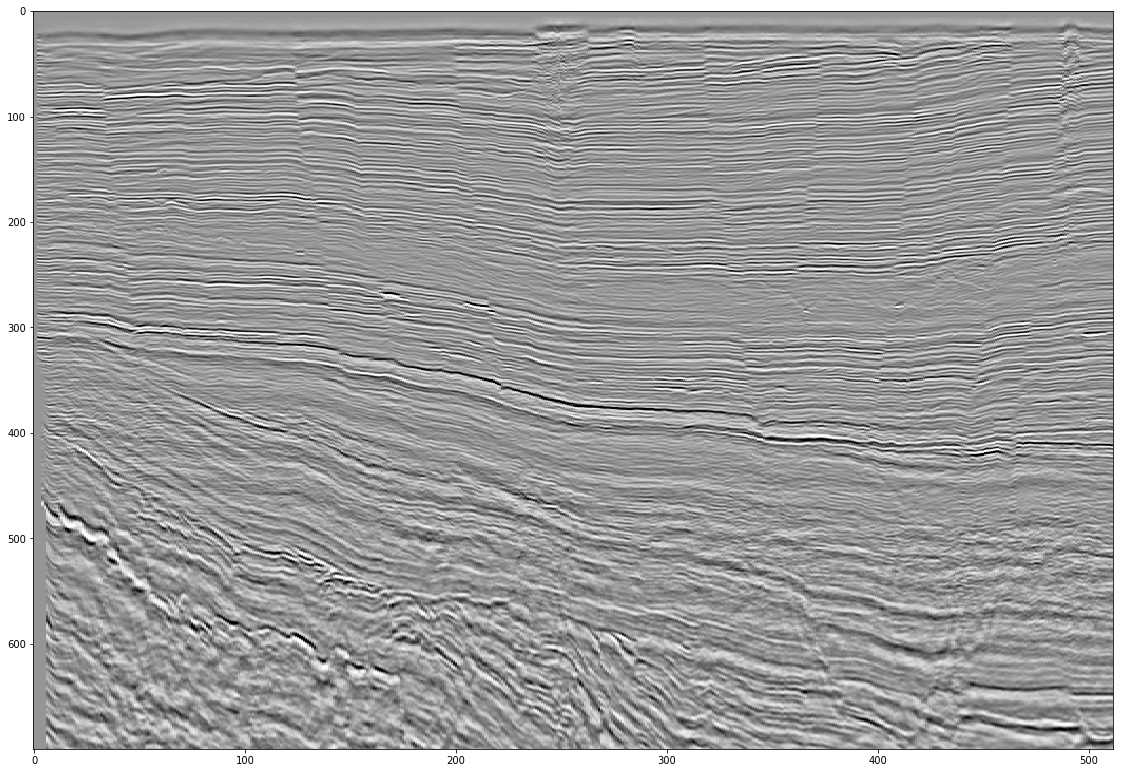

In [37]:
fig = plt.figure(frameon=False, figsize=(15, 15))
ax = fig.add_axes([0, 0, 1, 1])
ax.imshow(cube[100,:512,0:700].T, aspect=0.5, cmap='Greys', interpolation='nearest', clim=[-5,5])

# Make image "tiles" for annotation

We don't want null values in the training images, and we'll make an easier data set by considering only the easier to pick faults in the upper half of the section, so we'll set some limits for the x and y extents.

We'll make 6 images 100 x 100 pixels from left to right across each inline. Starting at crossline 50, ending at crossline 650.

In [57]:
import os

data_path = "training_data/seismic_test"
labels_path = "training_data/faults_test"

for path in [data_path, labels_path]:
    try:
        os.mkdir(path)
    except OSError:
        print ("Creation of the directory %s failed" % path)
    else:
        print ("Successfully created the directory %s " % path)

Successfully created the directory training_data/seismic_test 
Successfully created the directory training_data/faults_test 


In [58]:
minx = 50
miny = 100
dx, dy = 100, 100

first_inline = 30
last_inline = 250 
inline_inc = 10

In [59]:
# Tiles along the inline direction
for i in np.arange(first_inline, last_inline, inline_inc):
    for j in np.arange(1,7):
        section = cube[i,minx+(j-1)*dx:50+(j*dx),100:100+dy]
        fig = plt.figure(frameon=False, figsize=(section.shape[0]/40, section.shape[1]/40))
        ax = fig.add_axes([0, 0, 1, 1])
        ax.axis('off')
        ax.imshow(section.T, aspect=1.0, cmap='Greys', interpolation='nearest', clim=[-5,5])
        plt.savefig(f'{data_path}/section_{i}_{j}_inline.png', dpi=300)
        plt.close("all")

In [55]:
first_xline = 50
last_xline = 675 
xline_inc = 10

In [56]:
# Tiles along the xline direction

for i in np.arange(first_xline, last_xline, xline_inc):
    for j in np.arange(1,3):
        section = cube[minx+(j-1)*dx:50+(j*dx),i,100:100+dy]
        fig = plt.figure(frameon=False, figsize=(section.shape[0]/40, section.shape[1]/40))
        ax = fig.add_axes([0, 0, 1, 1])
        ax.axis('off')
        ax.imshow(section.T, aspect=1.0, cmap='Greys', interpolation='nearest', clim=[-5,5])
        plt.savefig(f'{data_path}/section_{i}_{j}_xline.png', dpi=300)
        plt.close("all")

# Extra: a time-slice just to show what the data looks like.

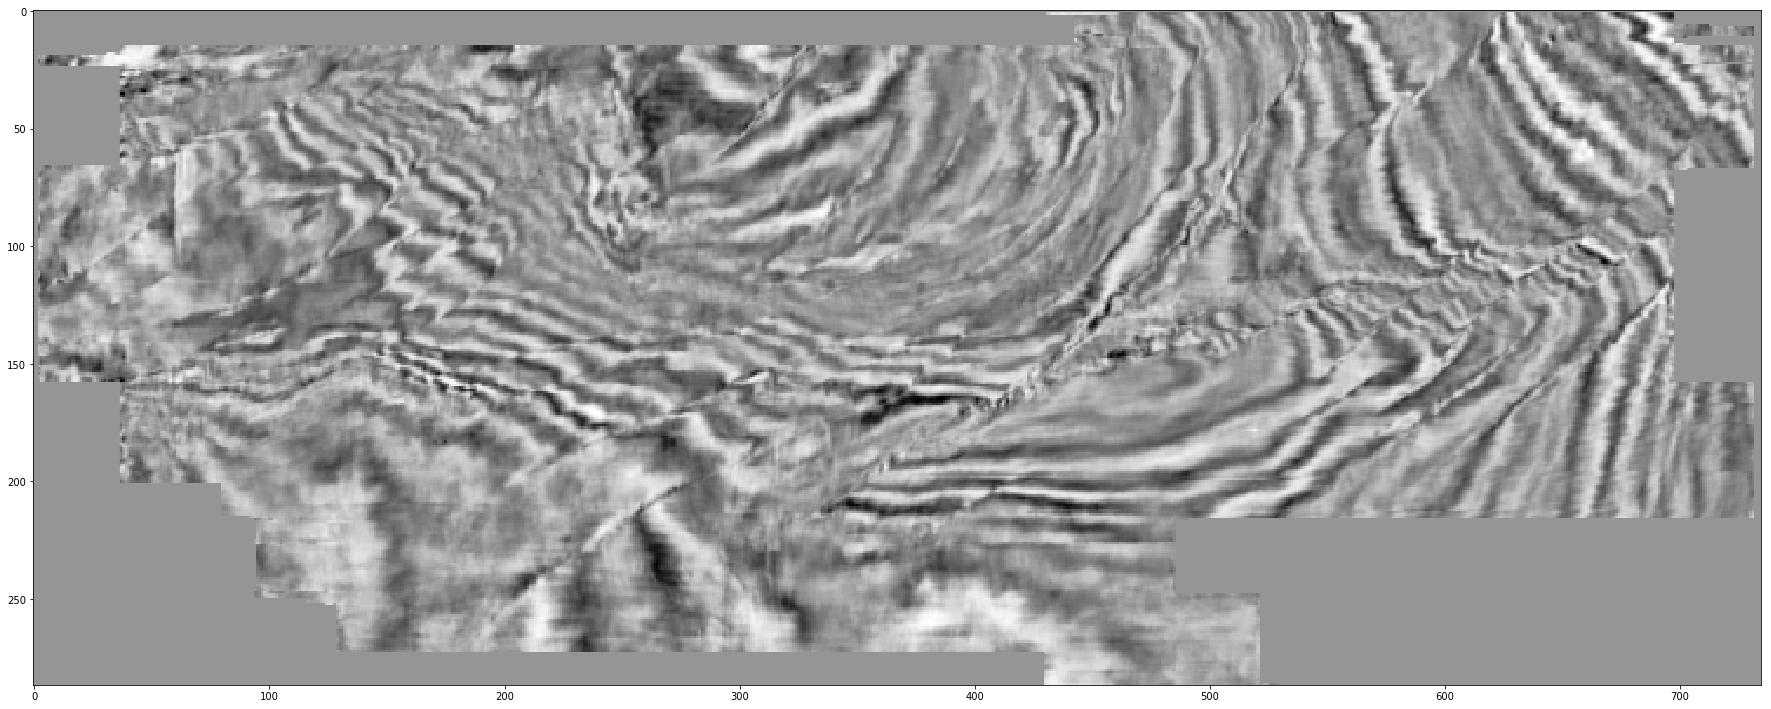

In [53]:
fig = plt.figure(frameon=False, figsize=(24, 20))
ax = fig.add_axes([0, 0, 1, 1])
ax.imshow(cube[:,:,150], aspect=1.0, cmap='Greys', interpolation='nearest', clim=[-5,5])